<a href="https://colab.research.google.com/github/its-Sohan/test/blob/main/FFT%26%26Fractal_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
# Importing libs in a separate Cell
import cv2
import numpy as np
#from skimage.restoration import denoise_bilateral
import matplotlib.pyplot as plt
#Ends here

In [72]:
# Importing libs in a separate Cell
import cv2
import numpy as np
#from skimage.restoration import denoise_bilateral
import matplotlib.pyplot as plt
#Ends here

# Image loading and error check
# Assuming the image is in the current directory, which is /content/ by default in Colab
img = cv2.imread("/content/drive/MyDrive/ALl AI test/anv9jj4c13ef1.jpeg", cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError("Image not found or failed to load. Please ensure the directory.")
img_float = img.astype(np.float32)

def adaptive_gamma_correction(image, gamma_min=0.5, gamma_max=2.0):
    """
    Apply adaptive gamma correction based on image brightness statistics
    """
    # Compute image statistics
    mean_val = np.mean(image)
    p95 = np.percentile(image, 95)

    # Calculate adaptive gamma
    # Darker images get lower gamma (brightening), brighter get higher gamma (darkening)
    gamma = gamma_min + (gamma_max - gamma_min) * (mean_val / 255)

    # Apply gamma correction
    corrected = np.power(image / 255.0, gamma)
    return corrected
#I dotn want high or overly contrasted/bright image to dominate the low power spectrum
#even if the visualization tell the image is brighter it works cz cv doesnt know how to show neg values
#brightnessaddjust = lambda addimg: (img - np.mean(addimg)).astype(np.float32)
# Normalize to [0, 1] (Floatng point value)32
#darker = (img * 0.99).astype(np.uint8)


# Apply adaptive gamma correction
img_gamma_crt = adaptive_gamma_correction(img)
# Apply bilateral filter to gamma-corrected image
denoised = cv2.bilateralFilter((img_gamma_crt * 255).astype(np.uint8),
                              d=12, sigmaColor=25, sigmaSpace=15)

denoised = denoised.astype(np.float32) / 255.0

# using cv2 bilateral filter
#denoised = cv2.bilateralFilter(img_norm.astype(np.uint8), d=12, sigmaColor=75, sigmaSpace=20)

# Denoise Stick to float until here
#denoised = denoise_bilateral(img_norm, sigma_color=0.1, sigma_spatial=10, channel_axis=None)
# converts to int array          i know its AI and already smootheed so no further neeed
# i  nt required here Memory Efficiency
#    float32 takes 4 bytes per pixel.
#    uint8 takes just 1 byte.
#denoised_8bit = (denoised * 255).astype(np.uint8) #denoisedd 8bit int
# residual

residual = (img_gamma_crt - denoised)


# FFT Processing with windowing
def compute_spectrum(image):
    row, col = image.shape
    win = np.outer(np.hamming(row), np.hamming(col))
    windowed = image * win
    fft = np.fft.fft2(windowed)
    fshift = np.fft.fftshift(fft)
    # Return the complex shifted FFT output, not the log magnitude
    return fshift
# Convert to float32 for FFT
'''
# A
fft = np.fft.fft2(residual)  # raw fft
fft_for_FSA = np.fft.fft2(denoised)
fshift = np.abs(np.fft.fftshift(fft)) #Fast fourier trasform Shifted to the center
# Compute magnitude
magnitude = np.abs(fshift)

#  Use logarithmic scale for visibility
magnitude_log =np.log(magnitude + 1)  # log(1 + x) for stability'''

'\n# A\nfft = np.fft.fft2(residual)  # raw fft\nfft_for_FSA = np.fft.fft2(denoised)\nfshift = np.abs(np.fft.fftshift(fft)) #Fast fourier trasform Shifted to the center\n# Compute magnitude\nmagnitude = np.abs(fshift)\n\n#  Use logarithmic scale for visibility\nmagnitude_log =np.log(magnitude + 1)  # log(1 + x) for stability'

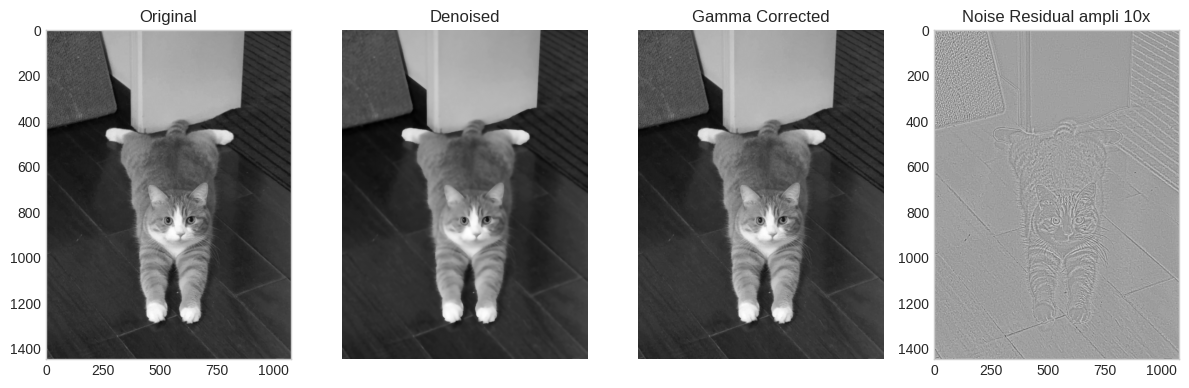

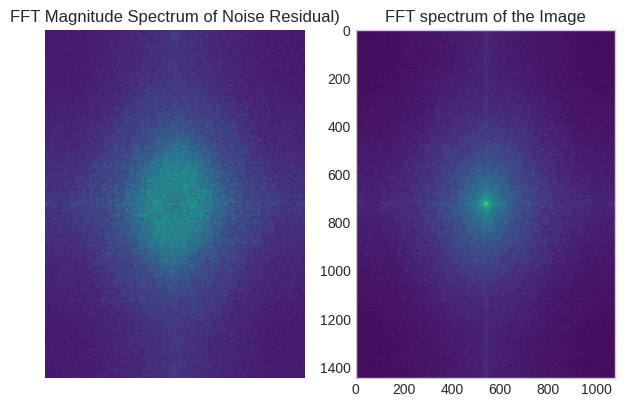

In [73]:
# Show all
plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.grid(False)
plt.title("Original")

plt.subplot(1, 4, 2)
plt.imshow(denoised, cmap='gray')
plt.title("Denoised")
plt.axis('off')

# Gamma-corrected image
plt.subplot(1,4,3)
plt.imshow(img_gamma_crt, cmap='gray')
plt.title('Gamma Corrected')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(residual)
plt.grid(False)
plt.title("Noise Residual ampli 10x")
plt.tight_layout()


plt.figure(figsize=(6, 6))
plt.subplot(1,2,1)
plt.title("FFT Magnitude Spectrum of Noise Residual)")
# Compute spectrum magnitude for visualization (optional, not for beta calculation)
residual_fshift = compute_spectrum(residual)
residual_magnitude_log = np.log(np.abs(residual_fshift) + 1)
plt.imshow(residual_magnitude_log, cmap='viridis')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("FFT spectrum of the Image")
# Compute spectrum magnitude for visualization (optional, not for beta calculation)
img_fshift = compute_spectrum(img_gamma_crt)
img_magnitude_log = np.log(np.abs(img_fshift) + 1)
plt.imshow(img_magnitude_log, cmap='viridis')
plt.grid(False)
plt.tight_layout()
plt.show()

In [74]:
def calculate_fractal_spectrum(fft_shifted_output, image_shape):
    num_pixels = image_shape[0] * image_shape[1] #for psd we needing the total pixel count image.shape[0] row image.shape[1] coloum
    # Calculate PSD from the shifted FFT output
    psd2D = (np.abs(fft_shifted_output)**2) / num_pixels #psd formula fft2d devided by total pixel GENERALL it's ENERGY PER PIXEL
    # psd2D_shifted = np.fft.fftshift(psd2D)  # The input is already shifted


    rows, cols = psd2D.shape
    center_row, center_col = rows // 2 , cols // 2
    y, x = np.indices((rows, cols))



    radius_grid = np.sqrt((x - center_col)**2 + (y - center_row)**2)# Calculate the Euclidean distance of each pixel from the center
    radius_grid_int = np.round(radius_grid).astype(int) # convert that to int

    # Round the radii to the nearest integer to use as bin indices
    #radius_grid = np.round(radius_grid).astype(int)

    # 4. Perform radial averaging to get the 1D PSD
    # We use np.bincount which is highly efficient for this task.
    # It sums up all PSD values (weights) that fall into each radial bin.
    psd_sum_by_bin = np.bincount(radius_grid_int.ravel(), psd2D.ravel())

    # Count the number of pixels in each radial bin
    pixels_per_bin = np.bincount(radius_grid_int.ravel())

    # Avoid division by zero for bins that might be empty
    non_zero_bins = pixels_per_bin > 0
    psd1D = psd_sum_by_bin[non_zero_bins] / pixels_per_bin[non_zero_bins]

    # The frequencies correspond to the bin numbers (the integer radii)
    freqs = np.arange(len(psd_sum_by_bin))[non_zero_bins]

    # 5. Fit a line to the log-log plot to find the spectral exponent (beta)
    # We must ignore the zero-frequency component (DC offset at freqs[0]) and
    # any zero power values, as log(0) is undefined.
    valid_indices = (freqs > 0) & (psd1D > 0)


    if not np.any(valid_indices):
        print("Warning: No valid frequency components found for fitting.")
        return freqs, psd1D, np.nan, np.nan

    log_freqs = np.log10(freqs[valid_indices])
    log_psd1D = np.log10(psd1D[valid_indices])

    # Fit a 1st degree polynomial (a line) to the log-log data.
    # The slope is the first element of the returned coefficients.
    try:
        coeffs = np.polyfit(log_freqs, log_psd1D, 1)
        # The spectral exponent β is the negative of the slope of the log-log plot.
        beta = -coeffs[0]
    except np.linalg.LinAlgError:
        print("Warning: Linear algebra error during polyfit. Could not determine slope.")
        beta = np.nan #nan means not a number

    # 6. Calculate the Fractal Dimension (D)
    # For a 2D image (representing a self-affine fractal surface), a common formula is:
    # D = (T*H + E) / H, where T is the topological dimension and E is the Euclidean dimension.
    # For a 2D surface (E=2) in 3D space, this simplifies with H = (beta - 1)/2 for fBm.
    # A more general and widely used formula relating D to beta for a 2D surface is:
    D = (7.0 - beta) / 2.0
    return freqs, psd1D, beta, D

In [75]:
    # --- Print and Visualize the results ---
    # 3. Calculate the fractal spectrum properties using the function
    # Pass the raw shifted FFT output from compute_spectrum
    freqs, psd1D, beta, D = calculate_fractal_spectrum(compute_spectrum(residual), img.shape) # Use img_gamma_crt here
    print(f"Image Shape: {img.shape}")
    print(f"Spectral Exponent (β): {beta:.4f}")
    print(f"Fractal Dimension (D): {D:.4f}")

Image Shape: (1448, 1079)
Spectral Exponent (β): 2.2043
Fractal Dimension (D): 2.3978


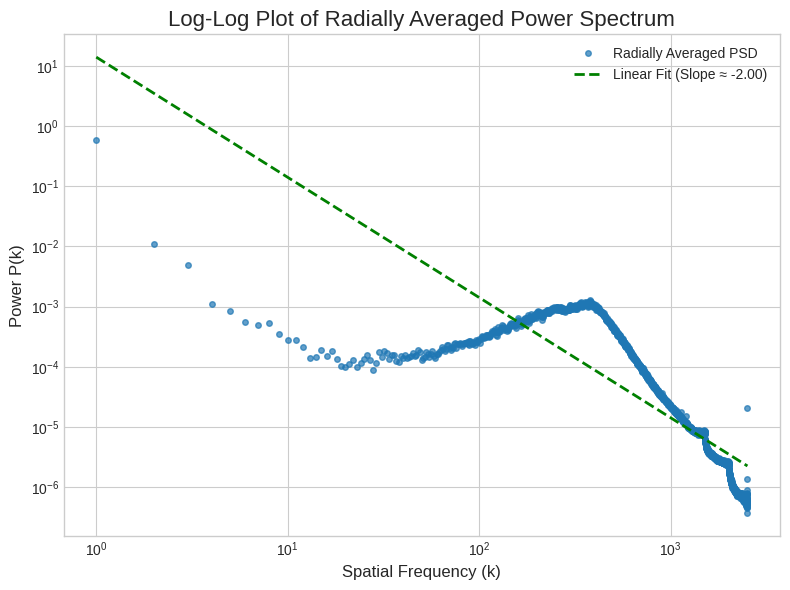

In [62]:
    # Create the log-log plot for visualization
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Plot the 1D Power Spectral Density
    valid_indices = (freqs > 0) & (psd1D > 0)
    ax.loglog(freqs[valid_indices], psd1D[valid_indices], 'o', markersize=4, alpha=0.7, label='Radially Averaged PSD')

    # Plot the fitted line
    if not np.isnan(beta):
        log_freqs = np.log10(freqs[valid_indices])
        coeffs = np.polyfit(np.log10(freqs[valid_indices]), np.log10(psd1D[valid_indices]), 1)
        slope = coeffs[0]
        intercept = coeffs[1]

        # Generate points for the fitted line
        fitted_line_log_freqs = np.linspace(log_freqs.min(), log_freqs.max(), 100)
        fitted_line_log_psd = slope * fitted_line_log_freqs + intercept

        ax.plot(10**fitted_line_log_freqs, 10**fitted_line_log_psd, 'g--', linewidth=2, label=f'Linear Fit (Slope ≈ {slope:.2f})')

    ax.set_title('Log-Log Plot of Radially Averaged Power Spectrum', fontsize=16)
    ax.set_xlabel('Spatial Frequency (k)', fontsize=12)
    ax.set_ylabel('Power P(k)', fontsize=12)
    ax.legend(fontsize=10)
    plt.tight_layout()
    plt.show()